# 使用Adaptive Optimization 

为了调参，需要指定一个实验的名称`EXP_NAME`，表明不同的Adaptive优化器的名称以及参数。对应的`logs`, `models`, `eval`的会有一个相同的文件夹保存对应的文件


In [53]:
DOCKER_NAME='nvcr.io/nvidia/clara-train-sdk:v3.0'
# 这个是物理机的数据集的路径
DATASET_PREFIX='/home/liuyuan/shu_codes/datasets/brats'
# RESNET 似乎不使用 pretrain
PRETRAIN_PATH='/home/liuyuan/shu_codes/pretrain_models/for_clara'

# FedAvg:
# EXP_NAME='fedavg_server_lr_1.0_client_lr_0.0001'
# FedAvgM
# EXP_NAME='fedavgm_server_lr_1.0_client_lr_0.0001_moment_0.9'
## FedAdam
EXP_NAME='fedadam_server_lr_1.0_client_lr_0.0001_eps_0.01'

Please enter the machine IP of local machine here (for tensorboard)

### MMAR

In Clara, we provide [MMAR (Model archive)](https://docs.nvidia.com/clara/tlt-mi/clara-train-sdk-v3.0/nvmidl/mmar.html) that contains everything necessary to get started. 

这个是为了确定使用那一个配置文件

In [54]:
MMAR_FOLDER="clara_seg_ct_brats_adaptive_fl"

!mkdir -p {MMAR_FOLDER}/logs/{EXP_NAME}

Let's have a look at the folder structure and the files that are important for the FL setup.

In [14]:
!ls -alh {MMAR_FOLDER}

total 80K
drwxr-xr-x 11 liuyuan liuyuan 4.0K Oct 10 09:56 .
drwxrwxr-x 12 liuyuan liuyuan 4.0K Oct 10 10:22 ..
drwxrwxr-x  3 liuyuan liuyuan 4.0K Oct  3 00:28 commands
drwxrwxr-x  4 liuyuan liuyuan 4.0K Oct  2 23:57 components
drwxrwxr-x  4 liuyuan liuyuan 4.0K Oct 10 10:29 config
drwxrwxr-x  3 liuyuan liuyuan 4.0K Oct  9 22:05 eval
drwxrwxr-x  2 liuyuan liuyuan 4.0K Oct  2 23:56 .ipynb_checkpoints
drwxrwxr-x  5 liuyuan liuyuan 4.0K Oct 10 10:08 logs
drwxrwxr-x  3 liuyuan liuyuan  40K Oct  9 22:05 models
drwxrwxr-x  3 liuyuan liuyuan 4.0K Oct  3 00:12 resources
drwxrwxr-x  3 liuyuan liuyuan 4.0K Oct 10 09:56 submit_brats_2020_validation


### Tensorboard

During training, we want to check the training progress. We will do this with tensorboard and both clients are configured to write tensorboard logs to the same file folder. The following commands starts a separate docker instance to run tensorboard, and provide a URL for accessing it.


In [72]:
%%bash --bg
docker stop tensorboard

In [108]:
%%bash -s "$MMAR_FOLDER" "$DOCKER_NAME" "$DATASET_PREFIX" "$EXP_NAME"
docker run --runtime=nvidia -dt --name tensorboard --rm --shm-size=10g --ulimit memlock=-1 --ulimit stack=67108864 \
    -v $PWD:/mmar \
    -v $3:/workspace/data \
    -p 19020:19020 \
    $2 \
    bash -c "tensorboard --host 0.0.0.0 --port 19020 --logdir /mmar/$1/models/$4/"

47a63c8820f65936f0e273127d6a49c341d82b6106a40f38671ba4abb9414a9d


After executing the cell (it may take a while if you are pulling the container for the first time), you can click on the link to open tensorboard in a new tab.

Now that we know how MMAR is structured and tensorboard is running, we can configure the server and the clients for FL. 

## Launch Server

The following diagram shows the server workflow:

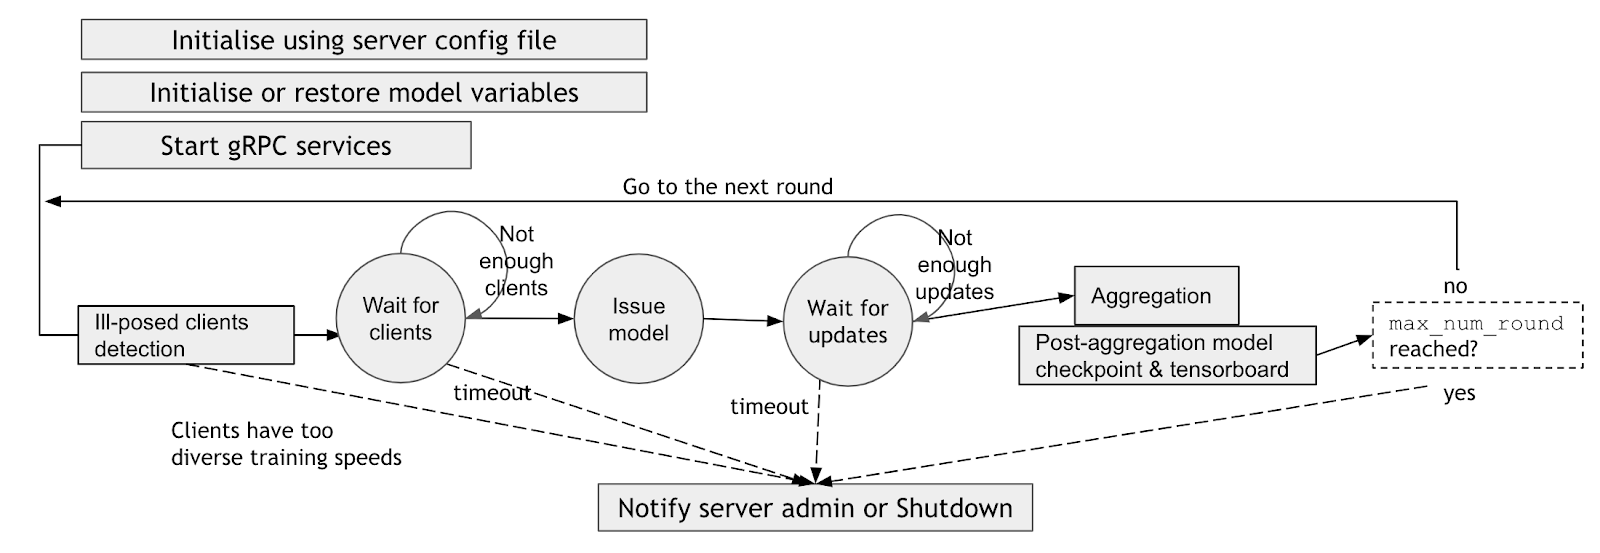

In [11]:
display(Image(filename='figures/fl_server_workflow.png'))

###  Configuration 
A federated server is responsible for:
1. Initialising a global model at federated round 0
1. Sharing the global model with all clients
1. Synchronising model updates from multiple clients
1. Updating the global model when sufficient model updates received

The configurations for the server are specified in the "config_fed_server.json" file: 

In [55]:
! cat {MMAR_FOLDER}/config/config_fed_server/{EXP_NAME}.json

{
    "servers": [
        {
            "name": "brats_segmentation",
            "service": {
                "target": "192.168.1.101:28004",
                "options": [
                    ["grpc.max_send_message_length",    1000000000],
                    ["grpc.max_receive_message_length", 1000000000]
                ]
            },
            "ssl_private_key": "resources/certs/server.key",
            "ssl_cert": "resources/certs/server.crt",
            "ssl_root_cert": "resources/certs/rootCA.pem",
            "min_num_clients": 2,
            "max_num_clients": 100,
            "wait_after_min_clients": 10,
            "heart_beat_timeout": 60000,
            "start_round": 0,
            "num_rounds": 200,
            "exclude_vars": "dummy",
            "num_server_workers": 100
        }
    ],
    "aggregator":
      {
        "name": "AdaptiveAggregator",
        "path": "adaptive_optimizers.aggregator.AdaptiveAggregator",
        "args": {
          "exclude_vars":

In the "config_fed_server.json" shown above, the server is configured to
1. listen on port 8002 on the localhost (`target` set to `localhost:8002`)
2. wait for at least 2 clients' update submission at each federated round (`min_num_clients` set to `2`)
3. Wait 10 seconds after the min no of clients join before starting rounds (`wait_after_min_clients` is set to 10).
4. `ssl_*` parameters are related to authentication.
5. Client sends heartbeat every minutes. `heart_beat_timeout` is set to detect if client is killed.
6. `aggregator` defines the type of aggregation. You can also point here to your own aggregator.

<font color='red'>Note: In this tutorial, we'll be using insecure training so the `ssl_*` parameters are ignored.</font>

**BEFORE YOU MOVE FORWARD, PLEASE REPLACE THE IP ADDRESS (localhost) IN "target": "< IP_address > :8002" with the IP ADDRESS OF YOUR MACHINE.**
You can do this by navigating to the file explorer of this jupyter notebook and editing it there or overwriting the file here.

###  Test the server 

Let's checkout `start_server_demo.sh` and start our server. We can start the server and run in the background:

In [17]:
!cat {MMAR_FOLDER}/commands/start_server_demo.sh



#!/usr/bin/env bash

my_dir="$(dirname "$0")"
. $my_dir/set_env.sh

echo "MMAR_ROOT set to $MMAR_ROOT"
echo "Experiment name is $1"
export CUDA_VISIBLE_DEVICES=

# Data list containing all data
CONFIG_FILE=config/config_train.json
SERVER_FILE=config/config_fed_server/$1.json
ENVIRONMENT_FILE=config/environment.json

python3 -u  -m nvmidl.apps.fed_learn.server.fed_aggregate \
    -m $MMAR_ROOT \
    -c $CONFIG_FILE \
    -e $ENVIRONMENT_FILE \
    -s $SERVER_FILE \
    --set \
    DATASET_JSON=$MMAR_ROOT/config/fl_dataset_0.json \
    MMAR_CKPT_DIR="models/$1" \
    secure_train=false




Let's use `start_server_demo.sh` to start the container for the server (here named 'server_app'):

In [64]:
%%bash --bg
docker stop server_app

In [65]:
%%bash -s "$DOCKER_NAME" "$MMAR_FOLDER" "$PRETRAIN_PATH" "$DATASET_PREFIX" "$EXP_NAME"
docker run --name server_app --rm -dt --shm-size=10g --ulimit memlock=-1 --ulimit stack=67108864 \
-v $PWD:/mmar \
-v $3:/workspace/pretrain \
-v $4:/workspace/data \
--ipc=host --net=host \
$1 \
bash -c "bash /mmar/$2/commands/start_server_demo.sh $5 | tee /mmar/$2/logs/$5/server_log.tmp"

508ebb68db8670590282d25c0a503bf53098fc6de37473e20d9979ccb859df32


Give it some time to start and then check the server's log:

In [25]:
!cat {MMAR_FOLDER}/logs/{EXP_NAME}/server_log.tmp

Replacing some pre-defined components...
'/mmar/clara_seg_ct_brats_adaptive_fl/commands/../components/server_model_manager.py' -> '/opt/nvidia/medical/fed_learn/server/server_model_manager.py'
'/mmar/clara_seg_ct_brats_adaptive_fl/commands/../components/fed_server.py' -> '/opt/nvidia/medical/fed_learn/server/fed_server.py'
MMAR_ROOT set to /mmar/clara_seg_ct_brats_adaptive_fl/commands/..
Experiment name is fedavgm_server_lr_1.0_client_lr_0.0001_moment_0.9
2020-10-10 02:41:17,677 - __main__ - INFO - Starting aggregation server with config:
2020-10-10 02:41:17,677 - __main__ - INFO - config/config_fed_server/fedavgm_server_lr_1.0_client_lr_0.0001_moment_0.9.json
2020-10-10 02:41:18,045 - AdaptiveAggregator - INFO - optimizer select: fedavgm, initialized with parameters : {'momentum': 0.9}, server_lr: 1.0


If the output of the previous cell shows **FederatedServer - INFO - starting insecure server at < your_ip >:8002** it means that the configuration works fine and the server is up and running. 
If not, try to execute previous cell again. Maybe it was still in the process. Ready? Good, server is there, let's launch the clients.


##  Lauch Client

The following diagram shows the client workflow:

###  Configuration
A federated client will:
1. download the global model
1. train the model with local training data
1. upload `delta_w` (the difference between the updated model and the global model) to the server

Let's inspect the `config_fed_client.json`:

In [27]:
! cat {MMAR_FOLDER}/config/config_fed_client.json

{
    "servers": [
        {
            "name": "brats_segmentation",
            "service": {
                "target": "192.168.1.101:28004",
                "options": [
                    ["grpc.max_send_message_length",    1000000000],
                    ["grpc.max_receive_message_length", 1000000000]
                ]
            }
        }
    ],
    "client": {
        "local_epochs": 1,
        "steps_aggregation": 0,
        "exclude_vars": "dummy",
        "privacy": {
        },
        "data_assembler": {
            "name": "DataAssembler"
        },
        "retry_timeout": 30,
        "ssl_private_key": "resources/certs/client1.key",
        "ssl_cert": "resources/certs/client1.crt",
        "ssl_root_cert": "resources/certs/rootCA.pem"
    }
}


In the `config_fed_client.json` shown above, the client is configured to:
* fetch global model from server at `localhost:8002` on local host (`target` set to `localhost:8002`)
* run 5 local epochs before submitting the `delta_w` to the server (`local_epochs` set to `5`)
* `privacy` can be used to define a custom privacy component. 
* `ssl_*` parameters are used for authentication.
    * Since we are using insecure training, these parameters are not used. 
    * If we use secure training, we'll have two such configs with each containing the respective client's authentication files.
    * For more details, please see [client configuration](https://docs.nvidia.com/clara/tlt-mi/clara-train-sdk-v3.0/nvmidl/additional_features/federated_learning.html#fl-client-configuration).

**BEFORE YOU MOVE FORWARD, PLEASE REPLACE THE IP ADDRESS (localhost) IN "target": "< IP_address > :8002" with the IP ADDRESS OF YOUR MACHINE.**
You can do this by navigating to the file explorer of this jupyter notebook and editing it there or overwriting the file here.

The local training workflow is defined by `config/config_train.json`, similar to the not-FL Clara train workflow. 

In the next section, we'll start two federated training clients.

###  Test the client

This mmar contains scripts to start two clients `client0_demo_train.sh` and `client1_demo_train.sh`. In other CLARA MMARs only one client training script is given (as clients are usually on different machines) and can be replicated many times.

<font color='red'>Note: This MMAR uses _demo_ scripts that remove the requirement of secure training. 

# 这里服务端和客户端不要用 localhost!!! 这里使用的服务端的内网地址

In [28]:
!cat {MMAR_FOLDER}/commands/client0_demo_train.sh

#!/usr/bin/env bash

my_dir="$(dirname "$0")"
. $my_dir/set_env.sh

echo "MMAR_ROOT set to $MMAR_ROOT"

# Data list containing all data
CONFIG_FILE=config/config_train.json
CLIENT_FILE=config/config_fed_client.json
ENVIRONMENT_FILE=config/environment.json

python3 -u  -m nvmidl.apps.fed_learn.client.fed_local_train \
    -m $MMAR_ROOT \
    -c $CONFIG_FILE \
    -e $ENVIRONMENT_FILE \
    -s $CLIENT_FILE \
    --set \
    DATASET_JSON=$MMAR_ROOT/config/fl_dataset_0.json \
    DATA_LIST_KEY=validation \
    secure_train=false \
    uid=client0


Let's run the two clients in separate dockers. If running on single machine, we should use separate GPU for each client. 

In [63]:
%%bash --bg
docker stop client_0
docker stop client_1
docker stop client_2
docker stop client_3
docker stop client_4
docker stop client_5

In [66]:
%%bash -s "$DOCKER_NAME" "$DATASET_PREFIX" "$MMAR_FOLDER" "$PRETRAIN_PATH" "$EXP_NAME"
docker run --runtime=nvidia --name client_0 --rm -dt --shm-size=20g --ulimit memlock=-1 --ulimit stack=67108864 \
    -e NVIDIA_VISIBLE_DEVICES=3 \
    -v $PWD:/mmar \
    -v $2:/workspace/data \
    -v $4:/workspace/pretrain \
    $1 \
    bash -c "bash /mmar/$3/commands/client0_demo_train.sh  2>&1 | tee /mmar/$3/logs/$5/client_0_log.tmp"

9b07ea4f953029104b624d0c4cad52abdc8d1aaf8a327820ad96be7129ce8e25


In [67]:
%%bash -s "$DOCKER_NAME" "$DATASET_PREFIX" "$MMAR_FOLDER" "$PRETRAIN_PATH" "$EXP_NAME"
docker run --runtime=nvidia --name client_1 --rm -dt --shm-size=20g --ulimit memlock=-1 --ulimit stack=67108864 \
    -e NVIDIA_VISIBLE_DEVICES=4 \
    -v $PWD:/mmar \
    -v $2:/workspace/data \
    -v $4:/workspace/pretrain \
    $1 \
    bash -c "bash /mmar/$3/commands/client1_demo_train.sh  2>&1 | tee /mmar/$3/logs/$5/client_1_log.tmp"

d051c161c847fc0dd398a7b4783d34a1b143767f12417b102a7d99c8b80a4e44


In [68]:
%%bash -s "$DOCKER_NAME" "$DATASET_PREFIX" "$MMAR_FOLDER" "$PRETRAIN_PATH" "$EXP_NAME"
docker run --runtime=nvidia --name client_2 --rm -dt --shm-size=20g --ulimit memlock=-1 --ulimit stack=67108864 \
    -e NVIDIA_VISIBLE_DEVICES=5 \
    -v $PWD:/mmar \
    -v $2:/workspace/data \
    -v $4:/workspace/pretrain \
    $1 \
    bash -c "bash /mmar/$3/commands/client2_demo_train.sh  2>&1 | tee /mmar/$3/logs/$5/client_2_log.tmp"

576a5311b089a0c53ef65a4542edd4fbfc75579019759c7afadc23ec58e8a880


In [69]:
%%bash -s "$DOCKER_NAME" "$DATASET_PREFIX" "$MMAR_FOLDER" "$PRETRAIN_PATH" "$EXP_NAME"
docker run --runtime=nvidia --name client_3 --rm -dt --shm-size=20g --ulimit memlock=-1 --ulimit stack=67108864 \
    -e NVIDIA_VISIBLE_DEVICES=6 \
    -v $PWD:/mmar \
    -v $2:/workspace/data \
    -v $4:/workspace/pretrain \
    $1 \
    bash -c "bash /mmar/$3/commands/client3_demo_train.sh  2>&1 | tee /mmar/$3/logs/$5/client_3_log.tmp"

f00b09054cda8e58412d9c780ca276c5ab1164303389f1cb22ee382b1b5be0eb


In [70]:
%%bash -s "$DOCKER_NAME" "$DATASET_PREFIX" "$MMAR_FOLDER" "$PRETRAIN_PATH" "$EXP_NAME"
docker run --runtime=nvidia --name client_4 --rm -dt --shm-size=20g --ulimit memlock=-1 --ulimit stack=67108864 \
    -e NVIDIA_VISIBLE_DEVICES=7 \
    -v $PWD:/mmar \
    -v $2:/workspace/data \
    -v $4:/workspace/pretrain \
    $1 \
    bash -c "bash /mmar/$3/commands/client4_demo_train.sh  2>&1 | tee /mmar/$3/logs/$5/client_4_log.tmp"

eeb3db19e93e245964eaefb89f7b274696a18a37a702e7dd41333762b5bc3e67


In [71]:
%%bash -s "$DOCKER_NAME" "$DATASET_PREFIX" "$MMAR_FOLDER" "$PRETRAIN_PATH" "$EXP_NAME"
docker run --runtime=nvidia --name client_5 --rm -dt --shm-size=20g --ulimit memlock=-1 --ulimit stack=67108864 \
    -e NVIDIA_VISIBLE_DEVICES=2 \
    -v $PWD:/mmar \
    -v $2:/workspace/data \
    -v $4:/workspace/pretrain \
    $1 \
    bash -c "bash /mmar/$3/commands/client5_demo_train.sh  2>&1 | tee /mmar/$3/logs/$5/client_5_log.tmp"

5435413b7e5cd3977d3ae75449ab97873a241b5520aed395ab37e0a804d14a04


After running the federated clients for a few minutes, we can check the output messages:

In [86]:
# !tail {MMAR_FOLDER}/logs/client_0_log.tmp -n 20
!cat {MMAR_FOLDER}/logs/{EXP_NAME}/client_0_log.tmp

Replacing some pre-defined components...
'/mmar/clara_seg_ct_brats_adaptive_fl/commands/../components/server_model_manager.py' -> '/opt/nvidia/medical/fed_learn/server/server_model_manager.py'
'/mmar/clara_seg_ct_brats_adaptive_fl/commands/../components/fed_server.py' -> '/opt/nvidia/medical/fed_learn/server/fed_server.py'
MMAR_ROOT set to /mmar/clara_seg_ct_brats_adaptive_fl/commands/..
2020-10-02 16:32:55.019096: I tensorflow/stream_executor/platform/default/dso_loader.cc:42] Successfully opened dynamic library libcudart.so.10.1


--------------------------------------------------------------------------
[[28650,1],0]: A high-performance Open MPI point-to-point messaging module
was unable to find any relevant network interfaces:

Module: OpenFabrics (openib)
  Host: 62169f3fb56c

Another transport will be used instead, although this may result in
lower performance.

NOTE: You can disable this warning by setting the MCA parameter
btl_base_warn_component_unused to 0.
------------------

In [60]:
!tail {MMAR_FOLDER}/logs/{EXP_NAME}/client_1_log.tmp

2020-09-20 12:49:23.025333: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1763] Adding visible gpu devices: 0
2020-09-20 12:49:23.025374: I tensorflow/stream_executor/platform/default/dso_loader.cc:42] Successfully opened dynamic library libcudart.so.10.1
2020-09-20 12:49:23.361621: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1181] Device interconnect StreamExecutor with strength 1 edge matrix:
2020-09-20 12:49:23.361662: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1187]      0 
2020-09-20 12:49:23.361668: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1200] 0:   N 
2020-09-20 12:49:23.363324: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1326] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 10230 MB memory) -> physical GPU (device: 0, name: GeForce RTX 2080 Ti, pci bus id: 0000:b1:00.0, compute capability: 7.5)
Fitting with single gpu
2020-09-20 12:49:23,372 - SupervisedFitter - INFO - CLEAN START (global_variables_initializer)


In [50]:
!tail {MMAR_FOLDER}/logs/{EXP_NAME}/client_2_log.tmp

2020-09-20 12:41:13.383595: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1881] Running auto_mixed_precision graph optimizer
2020-09-20 12:41:13.383930: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1331] No whitelist ops found, nothing to do
2020-09-20 12:41:13.388691: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1331] No whitelist ops found, nothing to do
2020-09-20 12:41:13.390743: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1331] No whitelist ops found, nothing to do
2020-09-20 12:41:13.392273: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1331] No whitelist ops found, nothing to do
2020-09-20 12:41:13.393273: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1331] No whitelist ops found, nothing to do
2020-09-20 12:41:13.394914: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1331] No whitelist ops found, nothing to do
2020-09-20 12:41:13.462328: I tensorflow/core/grappler/

# 检查模型

In [ ]:

!md5sum {MMAR_FOLDER}/models/{EXP_NAME}/*.data-00000-of-00001
# 似乎 FL model 的结果和 final 的结果相同

# 输出分割后的结果

In [105]:
!cat {MMAR_FOLDER}/commands/infer.sh

#!/usr/bin/env bash

my_dir="$(dirname "$0")"
. $my_dir/set_env.sh

echo "MMAR_ROOT set to $MMAR_ROOT"
echo "Inference on round range: start=$1, end=$2, step=$3"
echo "Experiment name is $4"

start=$1
end=$2
step=$3
for ((i=$start;i<$end;i=i+$step))
do
  echo "Validation on round $i"
  report_path=${MMAR_ROOT}/eval/$4/result_on_round_$i
  mkdir -vp $report_path
  # Data list containing all data
  CONFIG_FILE=config/config_validation.json
  ENVIRONMENT_FILE=config/environment.json

  python3 -u  -m nvmidl.apps.evaluate \
      -m $MMAR_ROOT \
      -c $CONFIG_FILE \
      -e $ENVIRONMENT_FILE \
      --set \
      DATASET_JSON=$MMAR_ROOT/config/2018train_2019test.json \
      do_validation=false \
      output_infer_result=true \
      MMAR_EVAL_OUTPUT_PATH=$report_path \
      ROUND_NUM=$i
done


In [68]:
%%bash --bg
docker stop infer

In [91]:
%%bash -s "$DOCKER_NAME" "$DATASET_PREFIX" "$MMAR_FOLDER" "$PRETRAIN_PATH" "$EXP_NAME"
docker run --runtime=nvidia --name infer --rm -dt --shm-size=20g --ulimit memlock=-1 --ulimit stack=67108864 \
    -e NVIDIA_VISIBLE_DEVICES='4' \
    -v $PWD:/mmar \
    -v $2:/workspace/data \
    -v $4:/workspace/pretrain \
    $1 \
    bash -c "bash /mmar/$3/commands/infer.sh 199 2>&1 | tee /mmar/$3/logs/$5/infer.tmp"

c30d58e9c1d25afbe0f3b37191ac3024c25b27217dba7cf059e51e4f6a66a1c9


In [9]:
!cat {MMAR_FOLDER}/logs/{EXP_NAME}/infer.tmp

cat: clara_seg_ct_brats_adaptive_fl/logs/fedavg_server_lr_1.0_client_lr_0.0001/infer.tmp: No such file or directory


# INFER 提交相关结果
这里使用的是 BRATS2020 Validation 的数据集

In [152]:
!cat {MMAR_FOLDER}/commands/infer_submit.sh

#!/usr/bin/env bash

my_dir="$(dirname "$0")"
. $my_dir/set_env.sh

echo "MMAR_ROOT set to $MMAR_ROOT"
echo "Inference on round range: start=$1, end=$2, step=$3"
echo "Using data list file: $4"
echo "Experiment name is $5"

start=$1
end=$2
step=$3
for ((i=$start;i<$end;i=i+$step))
do
  echo "Validation on round $i"
  report_path=${MMAR_ROOT}/eval/$5/result_on_round_$i
  mkdir -vp $report_path
  # Data list containing all data
  CONFIG_FILE=config/config_validation.json
  ENVIRONMENT_FILE=config/environment.json

  python3 -u  -m nvmidl.apps.evaluate \
      -m $MMAR_ROOT \
      -c $CONFIG_FILE \
      -e $ENVIRONMENT_FILE \
      --set \
      DATASET_JSON=$4 \
      do_validation=false \
      output_infer_result=true \
      MMAR_CKPT_DIR=models/$5 \
      MMAR_EVAL_OUTPUT_PATH=$report_path \
      ROUND_NUM=$i
done


In [153]:
%%bash --bg
docker stop infer_submit

`infer_submit` 的参数：
1. 起始的 Round
2. 终止的 Round
3. 间隔 Round
4. 使用的配置文件（在训练的过程中，使用的 2019作为验证）
5. 实验名（`EXP_NAME`）


In [73]:
%%bash -s "$DOCKER_NAME" "$DATASET_PREFIX" "$MMAR_FOLDER" "$PRETRAIN_PATH" "$EXP_NAME"
docker run --runtime=nvidia --name infer_submit --rm -dt --shm-size=20g --ulimit memlock=-1 --ulimit stack=67108864 \
    -e NVIDIA_VISIBLE_DEVICES='4' \
    -v $PWD:/mmar \
    -v $2:/workspace/data \
    -v $4:/workspace/pretrain \
    $1 \
    bash -c "bash /mmar/$3/commands/infer_submit.sh 199 200 5 /mmar/$3/config/2020_validation_submit.json $5 2>&1 | tee /mmar/$3/logs/$5/infer_submit.tmp"

2b34630efd195517f56b66a12daa0d83272b92c182bf371eab8e4372f6273890


In [76]:
!cat {MMAR_FOLDER}/logs/{EXP_NAME}/infer_submit.tmp

Replacing some pre-defined components...
'/mmar/clara_seg_ct_brats_adaptive_fl/commands/../components/server_model_manager.py' -> '/opt/nvidia/medical/fed_learn/server/server_model_manager.py'
'/mmar/clara_seg_ct_brats_adaptive_fl/commands/../components/fed_server.py' -> '/opt/nvidia/medical/fed_learn/server/fed_server.py'
MMAR_ROOT set to /mmar/clara_seg_ct_brats_adaptive_fl/commands/..
Inference on round range: start=199, end=200, step=5
Using data list file: /mmar/clara_seg_ct_brats_adaptive_fl/config/2020_validation_submit.json
Experiment name is fedadam_server_lr_1.0_client_lr_0.0001_eps_0.01
Validation on round 199
mkdir: created directory '/mmar/clara_seg_ct_brats_adaptive_fl/commands/../eval/fedadam_server_lr_1.0_client_lr_0.0001_eps_0.01'
mkdir: created directory '/mmar/clara_seg_ct_brats_adaptive_fl/commands/../eval/fedadam_server_lr_1.0_client_lr_0.0001_eps_0.01/result_on_round_199'
2020-10-10 13:30:22.973485: I tensorflow/stream_executor/platform/default/dso_loader.cc:42] S

# 输出在测试集上的结果
这里使用的是与 BRATS2019 的训练数据集（客户端均是通过 BRATS2018 进行的训练）

In [10]:
!cat {MMAR_FOLDER}/commands/validate.sh

#!/usr/bin/env bash

my_dir="$(dirname "$0")"
. $my_dir/set_env.sh

echo "MMAR_ROOT set to $MMAR_ROOT"
echo "Validation on round range: start=$1, end=$2, step=$3"
echo "Experiment name is $4"

start=$1
end=$2
step=$3
for ((i=$start;i<$end;i=i+$step))
do
  echo "Validation on round $i"
  report_path=${MMAR_ROOT}/eval/result_on_round_$i
  mkdir -vp $report_path
  # Data list containing all data
  CONFIG_FILE=config/config_validation.json
  ENVIRONMENT_FILE=config/environment.json

  python3 -u  -m nvmidl.apps.evaluate \
      -m $MMAR_ROOT \
      -c $CONFIG_FILE \
      -e $ENVIRONMENT_FILE \
      --set \
      DATASET_JSON=$MMAR_ROOT/config/2018train_2019test.json \
      do_validation=true \
      output_infer_result=false \
      MMAR_EVAL_OUTPUT_PATH=$report_path \
      MMAR_CKPT_DIR="${MMAR_ROOT}/models/$4" \
      ROUND_NUM=$i
done


In [122]:
%%bash --bg
docker stop validate

In [94]:
%%bash -s "$DOCKER_NAME" "$DATASET_PREFIX" "$MMAR_FOLDER" "$PRETRAIN_PATH" "$EXP_NAME"
docker run --runtime=nvidia --name validate --rm -dt --shm-size=20g --ulimit memlock=-1 --ulimit stack=67108864 \
    -e NVIDIA_VISIBLE_DEVICES='7' \
    -v $PWD:/mmar \
    -v $2:/workspace/data \
    -v $4:/workspace/pretrain \
    $1 \
    bash -c "bash /mmar/$3/commands/validate.sh 199 200 5 $5 2>&1 | tee /mmar/$3/logs/$5/validate.tmp"

ebd5149083815808fbfc7196e910641f7ad31df90b0c4a7db2a6cd1464b66041


In [117]:
!cat {MMAR_FOLDER}/logs/{EXP_NAME}/validate.tmp

Replacing some pre-defined components...
'/mmar/clara_seg_ct_brats_adaptive_fl/commands/../components/server_model_manager.py' -> '/opt/nvidia/medical/fed_learn/server/server_model_manager.py'
'/mmar/clara_seg_ct_brats_adaptive_fl/commands/../components/fed_server.py' -> '/opt/nvidia/medical/fed_learn/server/fed_server.py'
MMAR_ROOT set to /mmar/clara_seg_ct_brats_adaptive_fl/commands/..
Validation on round range: start=199, end=200, step=5
Validation on round 199
mkdir: created directory '/mmar/clara_seg_ct_brats_adaptive_fl/commands/../eval/result_on_round_199'
2020-10-03 00:20:52.225296: I tensorflow/stream_executor/platform/default/dso_loader.cc:42] Successfully opened dynamic library libcudart.so.10.1


--------------------------------------------------------------------------
[[59326,1],0]: A high-performance Open MPI point-to-point messaging module
was unable to find any relevant network interfaces:

Module: OpenFabrics (openib)
  Host: ebd514908381

Another transport will be us

##  Demo Results

The training curves in the form of tensorboard logs are saved at `clara_seg_ct_spleen_fl_demo/models`.

Assuming you have started the tensorboard server at the beginning of this demo. This section reads the tensorboard values and visualises the validation curves.

In [ ]:
 # open tab into Tensorboard to check training progress
import webbrowser
import os
from IPython.core.display import display, HTML

%env MACHINE_IP=$MY_IP
%env TB_PORT=6006

# generate an URL
url = 'http://' + os.environ['MACHINE_IP'] + ':' + os.environ['TB_PORT']
display(HTML('<a href="' + url + '" target="_blank">Open Tensorboard</a>'))

<font color='red'>Since this is a simple demo run, the results will not show great accuracy. </font>

##  Longer Training & Results

This notebook comes with a `clara_seg_ct_spleen_fl` folder that contains a full clara MMAR for federated spleen training. Running this will take several hours so you can do so on your own time. We will show how to use this MMAR and the results obtained from it. 

### Running 

Running this MMAR is very similar to this demo. Navigate to commands directory and use:
1. **server_train.sh**: To run federated server.
2. **client_train.sh**: To run federated clients.
3. The configs are same as described above. For secure training, see CLARA documentation on setting up ssl. 


### Results

Below are the tensorboard logs of training runs from the above MMAR. The event files of one such run are included in the MMAR.

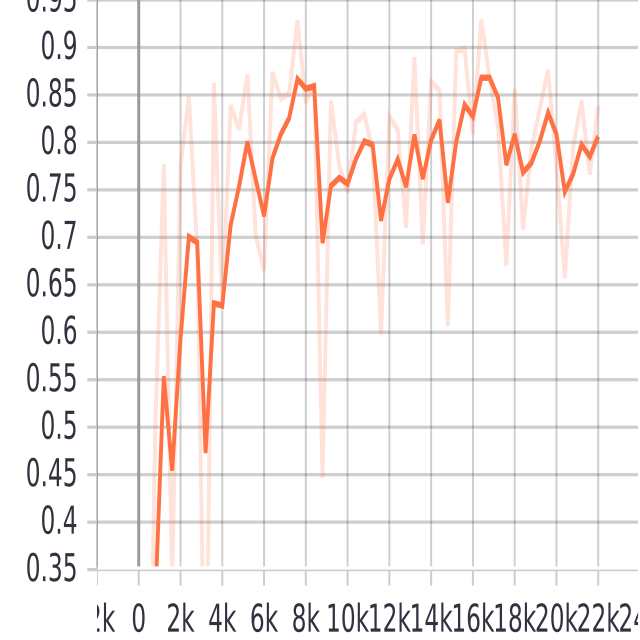

In [89]:
display(Image(filename='figures/normal_run/mean_dice.png', height = 250, width=250))

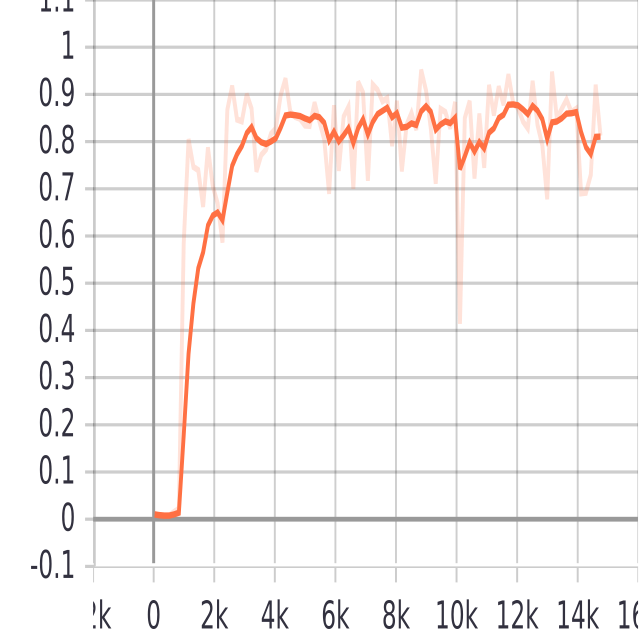

In [90]:
display(Image(filename='figures/client_0_run/mean_dice.png', height = 250, width=250))

In [ ]:
display(Image(filename='figures/client_1_run/mean_dice.png', height = 250, width=250))

# Summary
In this demo, we have configured and trained a federated model.

Two federated clients train the model with their own training data, and share model updates within the FL system;
the server hosts model parameters and synchronise model updates submitted by the two clients.

But this is only a simple demo. There are several features that we haven't investigated in this simple notebook, such as defining your own aggregation method or privacy method. But try it out! You can find all the information that you need in the [Clara documentation] (https://docs.nvidia.com/clara/tlt-mi/clara-train-sdk-v3.0/nvmidl/additional_features/federated_learning.html(. 

In [33]:
%%bash
docker stop server_app
docker stop client_0
docker stop client_1
docker stop client_2
docker stop tensorboard

server_app
client_0
client_1
client_2
tensorboard


In [90]:
!docker ps 

CONTAINER ID        IMAGE               COMMAND             CREATED             STATUS              PORTS               NAMES
